In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a048b18f88ac6f30481f74dfe70d93efdf615879f448f70a9b09f7dd9d977564
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from imblearn.over_sampling import SMOTE
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import numpy as np

In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

# Read the CSV file into a Spark DataFrame
data = spark.read.csv("Synthetic_Financial_Fraud.csv", header=True, inferSchema = True)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [4]:
# Show the schema and first few rows of the data
data.printSchema()
data.show(5)

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PA

In [5]:
# Perform basic EDA
data.groupBy("type").count().show()
data.groupBy("isFraud").count().show()


+--------+------+
|    type| count|
+--------+------+
|TRANSFER|133201|
| CASH_IN|351640|
|CASH_OUT|569883|
| PAYMENT|538364|
|   DEBIT| 10923|
+--------+------+

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   1768|
|      0|1602243|
+-------+-------+



In [6]:
# Add columns to identify the type of transaction
data = data.withColumn("isPayment", when(col("type") == "PAYMENT", 1).otherwise(0))
data = data.withColumn("isTransfer", when(col("type") == "TRANSFER", 1).otherwise(0))
data = data.withColumn("isCashOut", when(col("type") == "CASH_OUT", 1).otherwise(0))
data = data.withColumn("isDebit", when(col("type") == "DEBIT", 1).otherwise(0))

In [7]:
# Select relevant features for the model
feature_cols = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "isPayment", "isTransfer", "isCashOut", "isDebit"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [8]:
# Transform the data
data = assembler.transform(data)

In [13]:
# Convert Spark DataFrame to Pandas DataFrame for model training
pandas_df = data.select(*feature_cols, 'isFraud', 'type').toPandas()

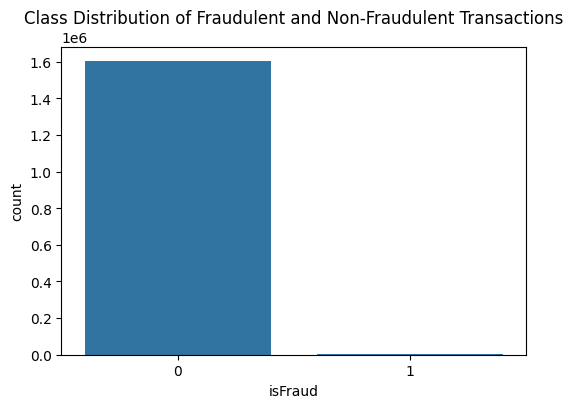

In [14]:
#Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=pandas_df)
plt.title('Class Distribution of Fraudulent and Non-Fraudulent Transactions')
plt.show()

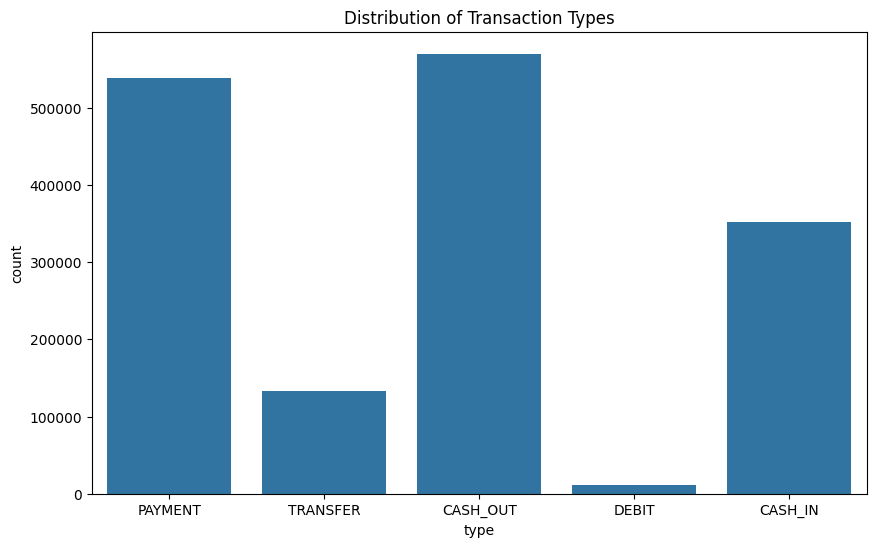

In [15]:
#Transaction Type Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='type', data=pandas_df)
plt.title('Distribution of Transaction Types')
plt.show()

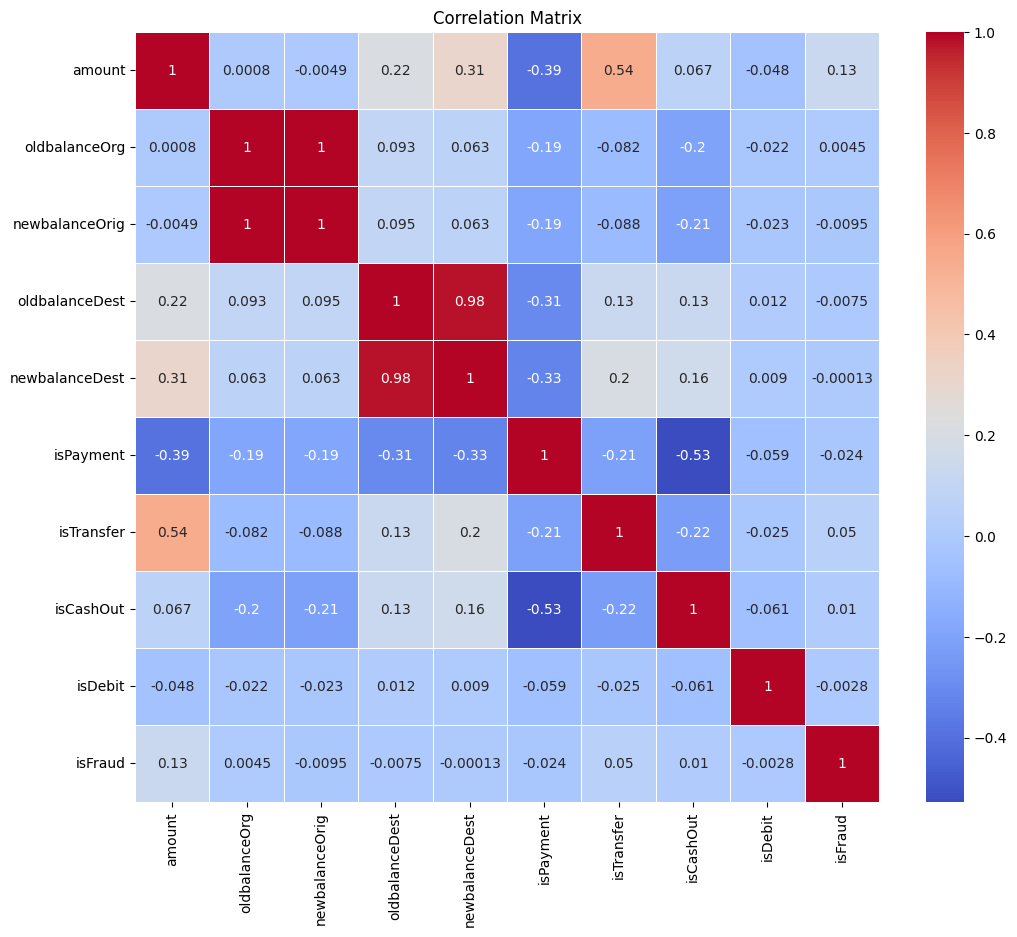

In [16]:
#Correlation Matrix
plt.figure(figsize=(12, 10))
corr_matrix = pandas_df[feature_cols + ['isFraud']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

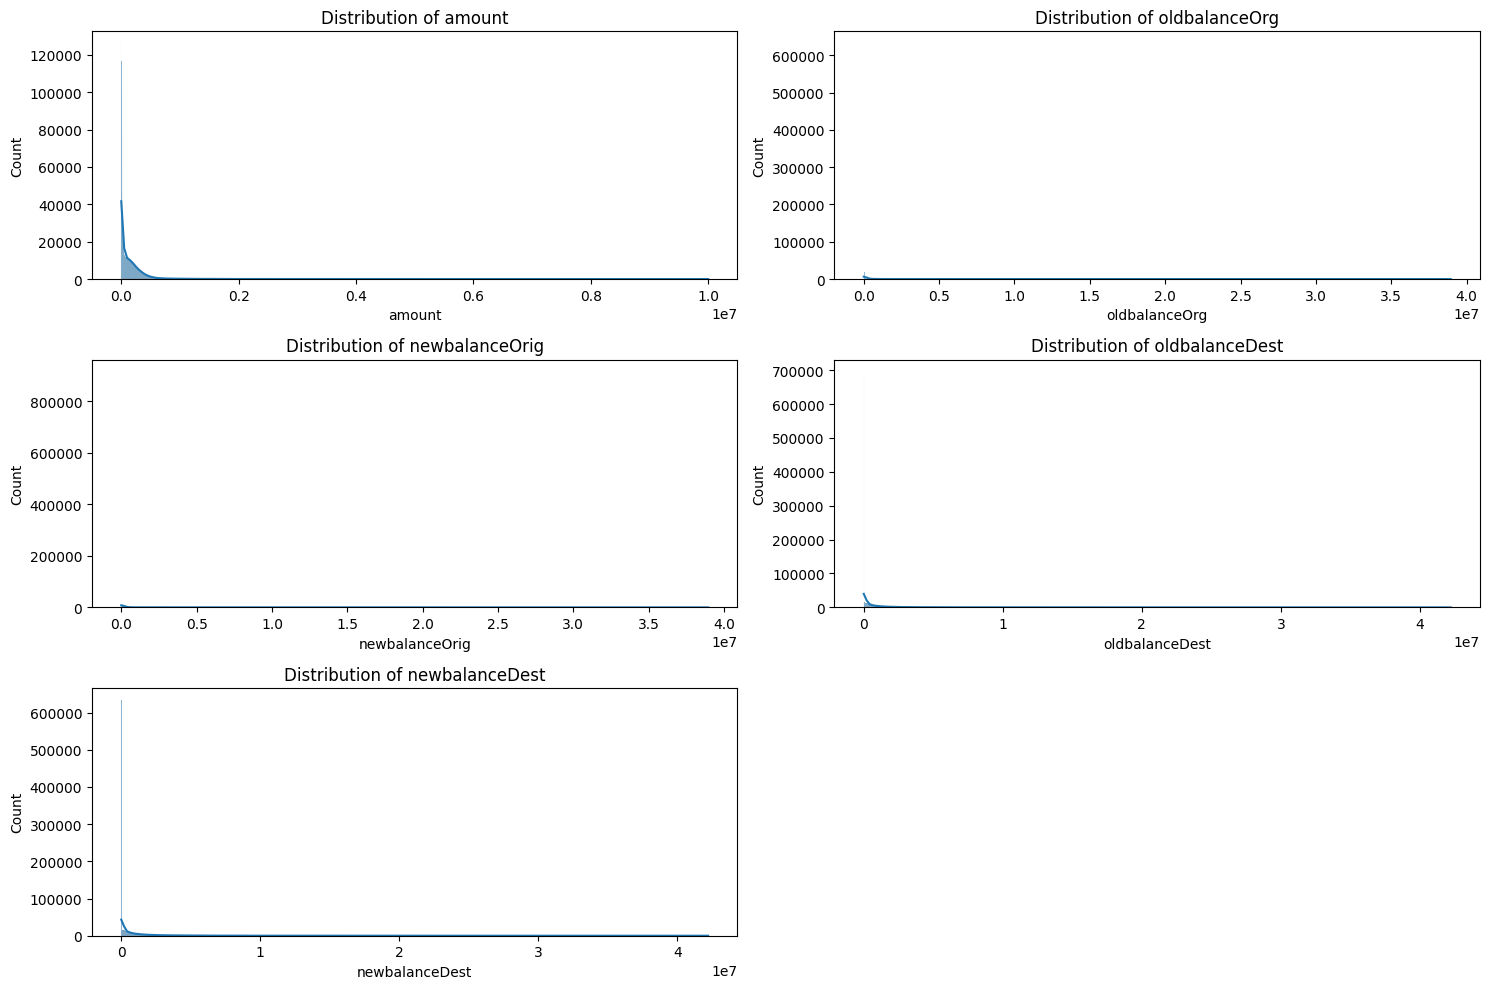

In [17]:
#Distribution of Key Numerical Features
numerical_features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(pandas_df[feature], kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()



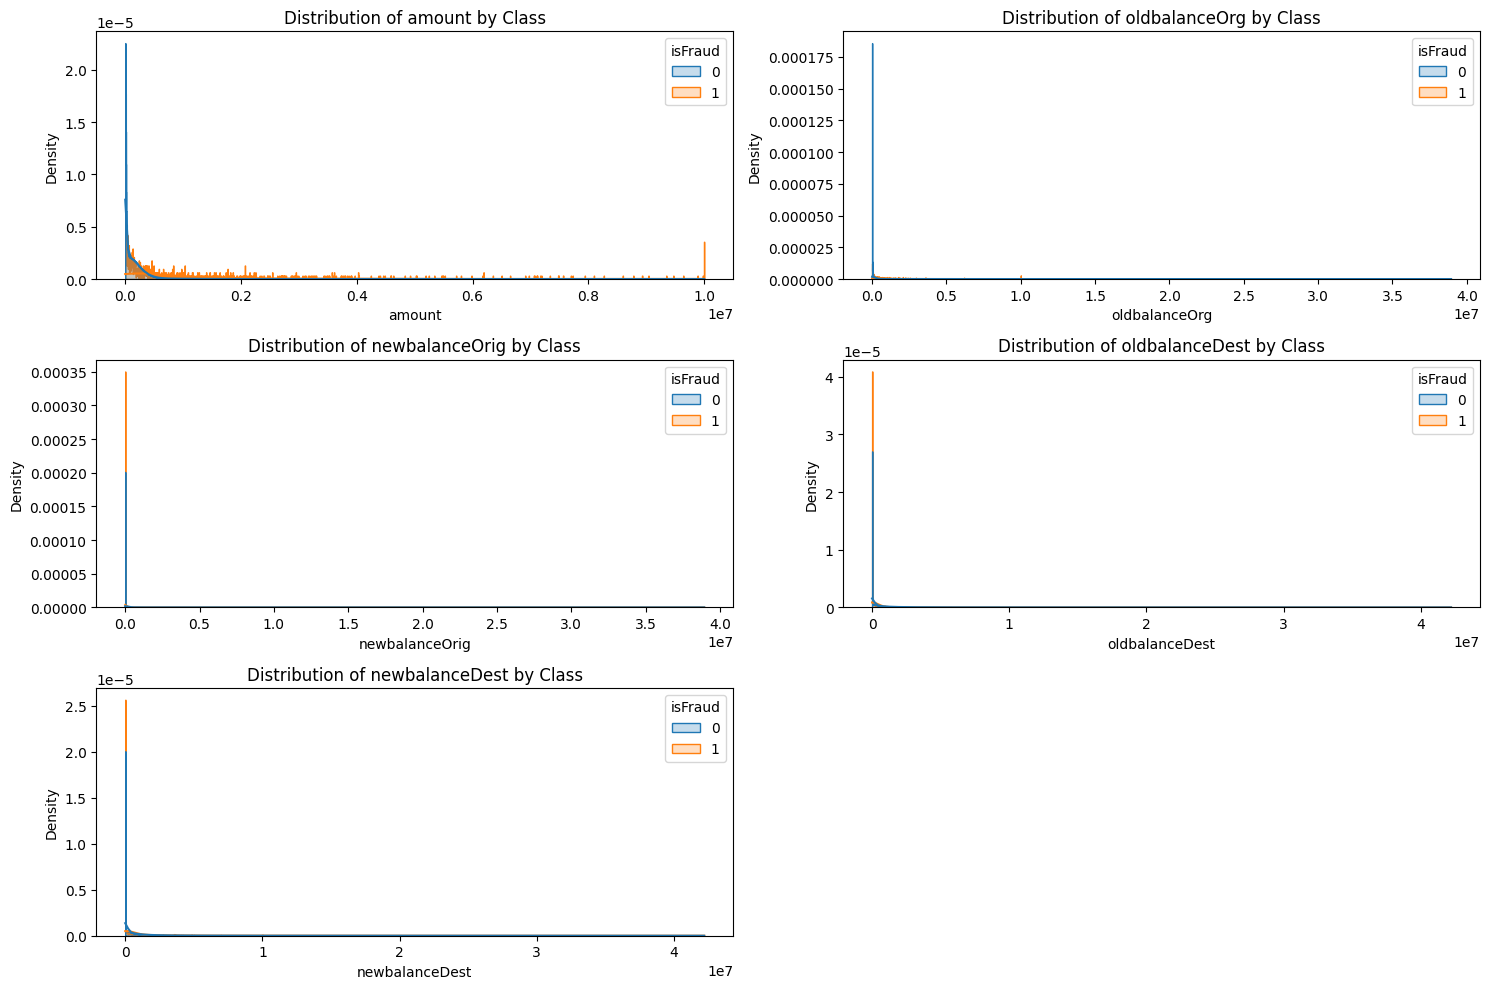

In [18]:
# Distribution of Key Numerical Features by Class
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=pandas_df, x=feature, hue='isFraud', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} by Class')
plt.tight_layout()
plt.show()

In [19]:
# Split data into features and labels
X = pandas_df[feature_cols]
y = pandas_df['isFraud']

In [20]:
# Import the necessary library
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Use fit_transform to fit and transform the data in a single step

In [21]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [22]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [38]:
# Import the necessary library
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Define a function to train, evaluate, and visualize the performance of different models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    # Predict probabilities
    y_pred_proba = model.predict(X_test)
    # Convert probabilities to binary predictions (0 or 1)
    y_pred = (y_pred_proba > 0.5).astype(int) # Adjust the threshold (0.5) if needed
    # Calculate evaluation metrics within the function
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    # Return the calculated metrics
    return accuracy, precision, recall, f1, auc, cm, y_pred

# Call the evaluate_model function with model and data
accuracy, precision, recall, f1, auc, cm, y_pred = evaluate_model(model, X_train, X_test, y_train, y_test)

# Now you can use the calculated metrics
print("Accuracy:", accuracy)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc}")
print("Confusion Matrix:")
print(cm)

10026/10026 [==============================] - 17s 2ms/step
Accuracy: 0.9994731969464126
Precision: 0.9502762430939227
Recall: 0.5180722891566265
F1 Score: 0.6705653021442495
AUC: 0.759022102746135
Confusion Matrix:
[[320462      9]
 [   160    172]]


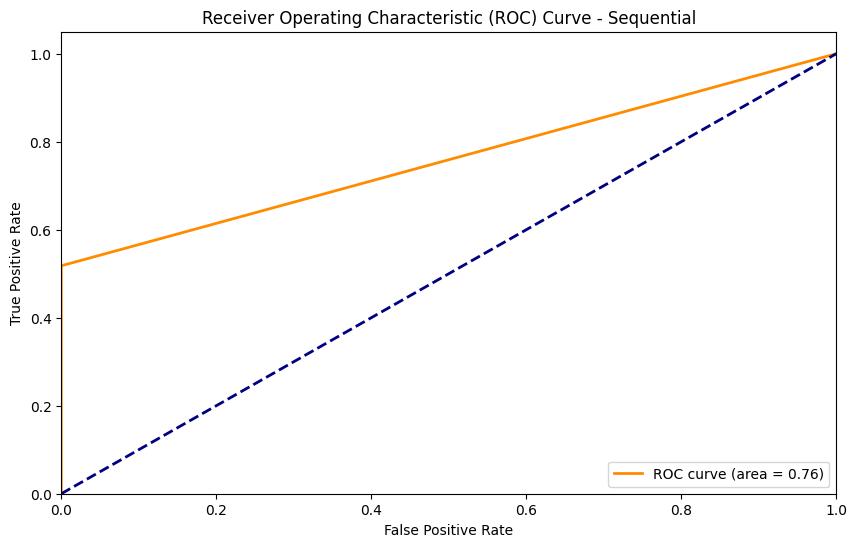

In [40]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model.__class__.__name__}')
plt.legend(loc="lower right")
plt.show()

In [43]:
!pip install --upgrade scikit-learn


In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Initialize the models
logistic_regression = LogisticRegression() # Remove max_iter, use default
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
gradient_boosting = GradientBoostingClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='linear', probability=True, random_state=42)

# Evaluate each model
for model in [logistic_regression, random_forest, gradient_boosting, svm]:
    evaluate_model(model, X_train, X_test, y_train, y_test)

In [24]:
# Define the neural network model
model = Sequential()
model.add(Dense(32, input_dim=len(feature_cols), activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [17]:
# Train the model with class weights
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, class_weight=class_weight_dict)


Epoch 1/20
52565/52565 [==============================] - 155s 3ms/step - loss: 0.3082 - accuracy: 0.8699 - val_loss: 0.2186 - val_accuracy: 0.8994
Epoch 2/20
52565/52565 [==============================] - 147s 3ms/step - loss: 0.2311 - accuracy: 0.9038 - val_loss: 0.1509 - val_accuracy: 0.9241
Epoch 3/20
52565/52565 [==============================] - 178s 3ms/step - loss: 0.2062 - accuracy: 0.9054 - val_loss: 0.1381 - val_accuracy: 0.9681
Epoch 4/20
52565/52565 [==============================] - 156s 3ms/step - loss: 0.2053 - accuracy: 0.9066 - val_loss: 0.1378 - val_accuracy: 0.9276
Epoch 5/20
52565/52565 [==============================] - 154s 3ms/step - loss: 0.1992 - accuracy: 0.9045 - val_loss: 0.0863 - val_accuracy: 0.9830
Epoch 6/20
52565/52565 [==============================] - 162s 3ms/step - loss: 0.2516 - accuracy: 0.9223 - val_loss: 0.1136 - val_accuracy: 0.9678
Epoch 7/20
52565/52565 [==============================] - 160s 3ms/step - loss: 0.1898 - accuracy: 0.9104 - val_

In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Neural Network - Accuracy: {accuracy}, Loss: {loss}")

16427/16427 [==============================] - 42s 3ms/step - loss: 0.1242 - accuracy: 0.9321
Neural Network - Accuracy: 0.9321447014808655, Loss: 0.12418507039546967


In [19]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

16427/16427 [==============================] - 25s 2ms/step


In [20]:
# Calculate precision, recall, and F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.012055872734327365
Recall: 0.9539473684210527
F1 Score: 0.023810827084131587


In [22]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix # Import the missing function

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[489545  35647]
 [    21    435]]


In [23]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

# Print confusion matrix with labels
print("Confusion Matrix:")
print("             Predicted Negative   Predicted Positive")
print("Actual Negative      ", cm[0][0], "                 ", cm[0][1])
print("Actual Positive      ", cm[1][0], "                 ", cm[1][1])

Confusion Matrix:
             Predicted Negative   Predicted Positive
Actual Negative       489545                   35647
Actual Positive       21                   435


In [25]:
# Calculate ROC curve and AUC
from sklearn.metrics import roc_curve, auc # Import the missing functions

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

AUC: 0.9430365716878679


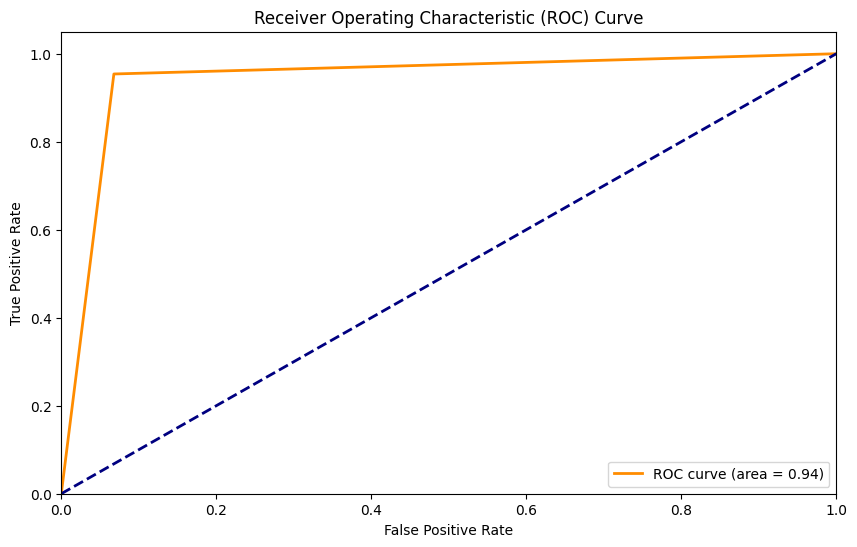

In [26]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming y_test and y_pred are already defined as your true and predicted labels

# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print results
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Accuracy: ", accuracy)

Precision:  0.012055872734327365
Recall:  0.9539473684210527
F1 Score:  0.023810827084131587
Accuracy:  0.9321447052019602
